In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import json
import math
import numpy as np

In [2]:
from utils import join_reference_set_and_results

In [3]:
with open('observational_results.txt') as f:
    observational_results = [json.loads(a) for a in f]

fname = '../reference_set.txt'

with open(fname) as f:
    reference_set = [json.loads(a) for a in f]

# Illustrate the format of these files
print(observational_results[0])

print(reference_set[0])

{'icd10codes': ['I21', 'I21.9'], 'atc_codes': [['A10BH01'], ['A10BA02']], 'results': {'cox': {'unadjusted': {'se': 0.027423460234602997, 'coef': 0.6649116462997681, 'p': 7.27115818984605e-130}, 'logistic_match': {'se': 0.03668112356057784, 'coef': 0.1318416921694853, 'p': 0.00032530814668214344}, 'lightgbm_match': {'se': 0.03665122519783611, 'coef': 0.24484905019566594, 'p': 2.38104429281256e-11}, 'logistic_ipw': {'se': 0.044480495055937465, 'coef': 0.09291333204879473, 'p': 0.036720721907434896}}, 'km': {'unadjusted': {'se': 3.0333777184930963, 'coef': -60.701237972185936, 'p': 0}, 'logistic_match': {'se': 3.340344516814828, 'coef': -6.197304215920212, 'p': 0}, 'lightgbm_match': {'se': 3.4244727494087375, 'coef': -16.578619802270623, 'p': 0}}}}
{'p': 0.6945612212128929, 'sub_infos': [{'side_effect_name': 'anaemia', 'drugs': ['Exemestane', 'Tamoxifen'], 'icd10codes': ['D64.9'], 'table': [[2, 2318], [4, 2334]], 'study': 'nct/NCT0003xxxx/NCT00038467.xml', 'atc_codes': [['L02BG06'], ['L02

In [4]:
joined = join_reference_set_and_results(reference_set, observational_results)
filtered = [a for a in joined if 'postmean' in a]

sorted_by_bayes = sorted(filtered, key=lambda v: v['postmean'])
print('Example entry: ', sorted_by_bayes[0])

Example entry:  {'p': 0.9976282611409322, 'sub_infos': [{'side_effect_name': 'acne', 'drugs': ['Cisplatin', 'Panitumumab'], 'icd10codes': ['L70.9', 'L70'], 'table': [[1, 155], [147, 12]], 'study': 'nct/NCT0082xxxx/NCT00820248.xml', 'atc_codes': [['L01XA01'], ['L01XC08']]}], 'postmean': -7.460003121818833, 'icd10codes': ['L70', 'L70.9'], 'table': [[1.0, 155.0], [147.0, 12.0]], 'lower': 0.0005756561714872761, 'upper': 0.0005756561714872761, 'atc_codes': [['L01XA01'], ['L01XC08']], 'results': {'cox': {'unadjusted': {'p': 8.93951324450761e-94, 'se': 0.09775960076980754, 'coef': -2.0082490144153904}, 'logistic_match': {'p': 4.886981260286399e-11, 'se': 0.34603995228099244, 'coef': -2.2749839153638973}, 'lightgbm_match': {'p': 0.00046184034164662227, 'se': 0.6146488906006751, 'coef': -2.1524788817205738}, 'logistic_ipw': {'p': 1.4237937560710374e-09, 'se': 0.3725477889652787, 'coef': -2.254944692723747}}, 'km': {'unadjusted': {'p': 0, 'se': 3.5733284257374356, 'coef': 36.17228275432046}, 'lo

{'a)': <Axes: label='a)'>, 'b)': <Axes: label='b)'>}
For method Unadjusted Cox, 56.39% are statistically significant
For method PSM Cox, 30.77% are statistically significant
For method IPSW Cox, 25.20% are statistically significant


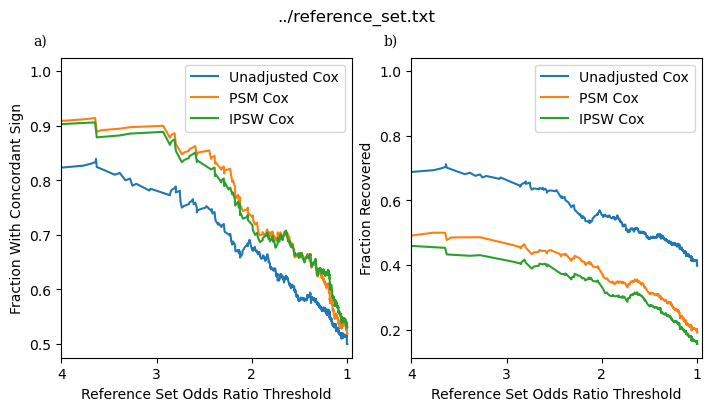

In [5]:
def compute_sign_rate_found(data, model_category, model_type):
    postmean = []
    fraction_correct = []
    fraction_found = []

    num_processed = 0
    num_correct_so_far = 0

    last_postmean = None
    
    for i, item in enumerate(data):
        results = item['results'][model_category][model_type]
        if results['p'] > 0.05:
            continue

        
        num_processed += 1
        if np.sign(results['coef']) == np.sign(item['postmean']):
            num_correct_so_far += 1

        if len(postmean) > 0 and postmean[-1] == math.exp(-item['postmean']):
            postmean.pop()
            fraction_correct.pop()
            fraction_found.pop()
            
        postmean.append(math.exp(-item['postmean']))
        fraction_correct.append(num_correct_so_far / num_processed)
        fraction_found.append(num_correct_so_far / (i + 1))


    return postmean, fraction_correct, fraction_found

methods = {
    'unadjusted': 'Unadjusted Cox',
    'logistic_match': 'PSM Cox',
    'logistic_ipw': 'IPSW Cox',
}

fig, axs = plt.subplot_mosaic([['a)', 'b)']],
                              layout='constrained', figsize=(7, 4))
print(axs)
for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif')


for method_key, method_name in methods.items():
    a, b, c = compute_sign_rate_found(sorted_by_bayes, 'cox', method_key)
    print(f'For method {method_name}, {len(a) / len(sorted_by_bayes) * 100:0.2f}% are statistically significant')
    
    axs['a)'].plot(a, b, label=method_name)
    axs['b)'].plot(a, c, label=method_name)

axs['a)'].set_xlim(4, 0.95)
axs['a)'].legend()
axs['a)'].set_xlabel("Reference Set Odds Ratio Threshold")
axs['a)'].set_ylabel("Fraction With Concordant Sign")


axs['b)'].set_xlim(4, 0.95)
axs['b)'].legend()
axs['b)'].set_xlabel("Reference Set Odds Ratio Threshold")
axs['b)'].set_ylabel("Fraction Recovered")
fig.suptitle(fname)
fig.savefig(fname.replace('.txt', '.png'))